In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from shapely.geometry import Point, box
import os



In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point, box

def country_plots(
    variable: xr.DataArray,
    cmap: str = 'RdBu_r',
    vmin: float = None,
    vmax: float = None,
    title: str = '',
    label: str = ''
):
    """
    Take a DataArray on dims (y,x), compute per-country means, and plot.
    
    - variable: xarray.DataArray with coords .x/.y in degrees
    - cmap: matplotlib colormap name
    - vmin/vmax: if None→use full data min/max; else→clip colorbar
    - title: plot title
    - label: colorbar label
    """
    # 1) Subset region
    da = variable.sel(x=slice(-12, 35), y=slice(33, 64))
    
    # 2) Flatten to a Pandas table of (lon, lat, value)
    xs, ys = da.x.values, da.y.values
    lon2d, lat2d = np.meshgrid(xs, ys)
    df = pd.DataFrame({
        'lon': lon2d.ravel(),
        'lat': lat2d.ravel(),
        'value': da.values.ravel()
    }).dropna(subset=['value'])
    
    # 3) Make a GeoDataFrame of points
    gdf_pts = gpd.GeoDataFrame(
        df,
        geometry=[Point(x, y) for x, y in zip(df.lon, df.lat)],
        crs="EPSG:4326"
    )
    
    # 4) Load high-res countries and clip to the box
    ne_50m = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
    world = gpd.read_file(ne_50m).to_crs("EPSG:4326")
    bbox = box(-12, 33, 35, 64)
    world = world.clip(bbox)
    
    # 5) Spatial join & compute country means
    joined = gpd.sjoin(
        gdf_pts, 
        world[['NAME_LONG','geometry']],
        how='inner',
        predicate='within'
    )
    country_means = (
        joined
        .groupby('NAME_LONG')['value']
        .mean()
        .reset_index(name='mean_diff')
    )
    world = world.merge(country_means, on='NAME_LONG', how='left')
    
    # 6) Decide on vmin/vmax
    if vmin is None and vmax is None:
        # full data range (no clipping)
        vmin_plot = world['mean_diff'].min()
        vmax_plot = world['mean_diff'].max()
    else:
        # user‐provided clipping
        vmin_plot, vmax_plot = vmin, vmax
    norm = mpl.colors.Normalize(vmin=vmin_plot, vmax=vmax_plot)
    
    # 7) Plot
    fig, ax = plt.subplots(
        figsize=(12, 8),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    world.plot(
        column='mean_diff',
        cmap=cmap,
        vmin=vmin_plot,
        vmax=vmax_plot,
        linewidth=0.5,
        edgecolor='black',
        ax=ax,
        missing_kwds={
            'color':'lightgrey',
            'edgecolor':'red',
            'hatch':'///',
            'label':'no data'
        }
    )
    
    # map styling
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.coastlines('10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_extent([-12, 35, 33, 64], ccrs.PlateCarree())
    ax.set_title(title, fontsize=16)
    
    # 1° gridlines
    gl = ax.gridlines(
        draw_labels=True,
        linewidth=0.5,
        color='gray',
        linestyle='--',
        xlocs=np.arange(-12, 36, 1),
        ylocs=np.arange(33, 65, 1)
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize':12,'rotation':45,'ha':'right'}
    gl.ylabel_style = {'fontsize':12}
    
    # colorbar
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label(label, rotation=90, labelpad=15, fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    
    plt.show()


In [3]:
# 1) PARAMETERS
models = [
    "ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2",
    "HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"
]
diri = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/"

# ─────────────────────────────────────────────────────────────────────────────
# 2) LOAD + COMPUTE GRID-CELL RELATIVE DIFFERENCES
relative_differences = {}
all_rel = []

for model in models:
    # historical
    boc = xr.concat([
        xr.open_dataset(os.path.join(diri, f"{model}_1x1grid/historical/aggregated_solar_power_{yr}.nc"))
          .expand_dims(time=[yr])
        for yr in range(1980, 2015)
    ], dim="time")
    mean_boc = boc["specific generation"].mean(dim="time")
    
    # future
    eoc = xr.concat([
        xr.open_dataset(os.path.join(diri, f"{model}_1x1grid/ssp585/aggregated_solar_power_{yr}.nc"))
          .expand_dims(time=[yr])
        for yr in range(2065, 2100)
    ], dim="time")
    mean_eoc = eoc["specific generation"].mean(dim="time")
    
    # percent change + subset
    rel = (mean_eoc - mean_boc) / mean_boc * 100
    rel = rel.sel(x=slice(-12, 35), y=slice(33, 65))
    
    relative_differences[model] = rel
    all_rel.append(rel)
    ensemble_grid = xr.concat(list(relative_differences.values()), dim="model").mean(dim="model")


In [15]:
vmin, vmax = np.nanpercentile(ensemble_grid.values, [0.5, 99.5])

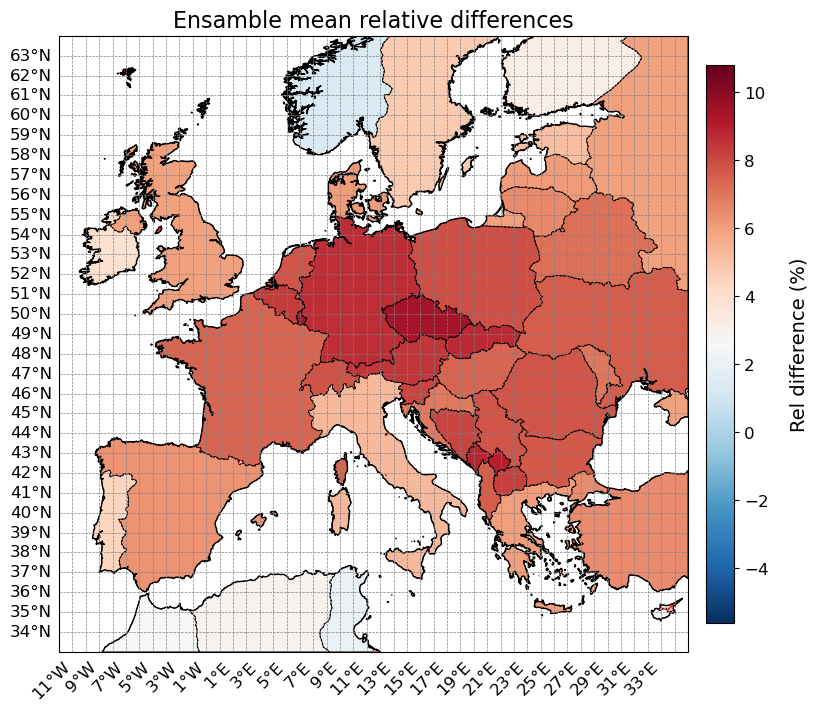

In [16]:
country_plots(
    variable=ensemble_grid,
    cmap='RdBu_r',
    vmin= vmin,
    vmax = vmax,
    title= 'Ensamble mean relative differences',
    label = 'Rel difference (%)',
)